# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import geopandas as gpd
from matplotlib import colors
from matplotlib import cm
import sys, os

# Syntax GKFCM

In [2]:
"""
Bagian ini merupakan bagian pendefinisian fungsi yang digunakan untuk
model GKFCM yang nanti digunakan pada data
"""

np.random.seed(42)

# fungsi gaussian_distance untuk menghitung nilai kernel gaussian data dengan pusat cluster
# Persamaan (2.6)
def gaussian_distance(data, centers, variance):
    np.random.seed(42)
    gaussian_dist = np.exp(-1*(np.linalg.norm(data[:, np.newaxis] - centers, axis=2)**2)/variance)
    return gaussian_dist


# fungsi update_membership untuk memperbarui nilai matriks keanggotaan data (nilai u_ij)
# Persamaan (2.7)
def update_membership(data, gaussian_dist, m, beta):
    np.random.seed(42)
    p = beta - beta * gaussian_dist
    p = np.fmax(p, np.finfo(np.float64).eps)
    p = (1/p) ** (1/(m-1))
    u_new = p / np.sum(p, axis=1, keepdims=True)
    u_new = np.fmax(u_new, np.finfo(np.float64).eps)
    return u_new


# fungsi calculate_centers untuk memperbarui titik pusat data (center atau v_j)
# Persamaan (2.8)
def calculate_centers(data, U, m, gaussian_dist, beta, n_clusters):
    centers = []
    for n in range(n_clusters):
        np.random.seed(42)
        um = U ** m
        p = um * beta * gaussian_dist
        p = p[:,n].reshape(-1,1)
        q = p * data
        center_i = np.sum(q, axis=0, keepdims=True)/np.sum(p, axis=0, keepdims=True)
        center_i = center_i[0]
        centers.append(center_i)
    centers = np.array(centers)
    return centers


# Fungsi ini digunakan untuk melakukan iterasi sampai diperoleh u_ij dan v_j maksimal
def gaussian_kernel_fuzzy_c_means(data, n_clusters, m, max_iters, tol, beta):
    np.random.seed(42)
    n_samples, n_features = data.shape
    U = np.random.rand(n_samples, n_clusters)
    U /= np.sum(U, axis=1, keepdims=True)
    centers = np.zeros((n_clusters, n_features))
    variance = np.var(data, ddof=1)

    # Iterasi memperbarui u_ij dan v_j
    for iteration in range(max_iters):
        print("\n")
        print("*"*30)
        print("Iterasi Ke-", iteration+1)
        np.random.seed(42)
        
        # Simpan nilai keanggotaan fuzzy sebelum diperbarui
        U_old = U.copy()
        
        
        # Langkah 1: Perbarui pusat klaster (Persamaan 2.8)
        gaussian_dist = gaussian_distance(data, centers, variance)
        centers = calculate_centers(data, U, m, gaussian_dist, beta, n_clusters)
        print("\nPusat Cluster Iterasi Ke-", iteration+1)
        print("Persamaan (2.8)")
        print(centers)
              
        
        # langkah 2: buat jarak gaussian (Persamaan 2.6)
        gaussian_dist = gaussian_distance(data, centers, variance)
        print("\nJarak Gaussian Iterasi Ke-", iteration+1)
        print("Persamaan (2.6)")
        print(gaussian_dist)
        
        
        # Langkah 3: Perbarui nilai keanggotaan fuzzy (Persamaan 2.7)
        U = update_membership(data, gaussian_dist, m, beta)
        print("\nMatriks Keanggotaan Fuzzy Terperbarui Iterasi Ke-", iteration+1)
        print("Persamaan (2.7)")
        print(U)

        
        # Hitung perubahan nilai keanggotaan fuzzy apakah susdah memenuhi ‖𝑈𝑞 − 𝑈𝑞−1‖ ≤ e
        diff = np.linalg.norm(U - U_old)
        print("\nU Sekarang - U Sebelumnya =", diff)
        
        # Jika ‖𝑈𝑞 − 𝑈𝑞−1‖ ≤ e sudah terpenuhi iterasi di hentikan
        if diff < tol:
            # print("Konvergensi tercapai pada iterasi ke-{}".format(iteration + 1))
            break

    return U, centers

# Import Data

In [3]:
# Import Data
df = pd.read_csv("data kriminal sulsel.csv", sep = ";")
df

# 𝑋1 Jumlah Kejahatan yang Dilaporkan 
# 𝑋2 Risiko Penduduk Terkena Kejahatan per 100.000 Penduduk
# 𝑋3 Persentase Penyelesaian Kejahatan
# 𝑋4 Selang Waktu Terjadinya Kejahatan

,ADM2_EN,X1,X2,X3,X4
0,Bantaeng,127,67.12,84.22,68.97
1,Barru,224,127.98,65.62,39.10
2,Bone,1669,220.25,72.79,5.24
3,Bulukumba,1350,319.93,65.55,6.48
4,Enrekang,153,72.86,124.18,57.25
5,Gowa,2215,287.33,71.24,3.95
6,Jeneponto,869,236.68,81.47,10.08
7,Kepulauan Selayar,275,202.03,58.54,31.85
8,Kota Makassar,10951,704.20,49.88,0.79
9,Kota Palopo,1207,643.14,62.05,7.25


In [4]:
# Mengubah Data Agar menjadi bentuk matriks sehingga dapat dimasukkan ke Persamaan
data = df.iloc[:, 1:]
data = data.values
np.set_printoptions(suppress=True)

data

array([[  127.  ,    67.12,    84.22,    68.97],
       [  224.  ,   127.98,    65.62,    39.1 ],
       [ 1669.  ,   220.25,    72.79,     5.24],
       [ 1350.  ,   319.93,    65.55,     6.48],
       [  153.  ,    72.86,   124.18,    57.25],
       [ 2215.  ,   287.33,    71.24,     3.95],
       [  869.  ,   236.68,    81.47,    10.08],
       [  275.  ,   202.03,    58.54,    31.85],
       [10951.  ,   704.2 ,    49.88,     0.79],
       [ 1207.  ,   643.14,    62.05,     7.25],
       [  464.  ,   315.45,    84.48,    18.87],
       [  689.  ,   186.25,    50.79,    12.71],
       [  367.  ,   120.37,    78.74,    23.86],
       [  741.  ,   232.97,    65.04,    11.82],
       [  750.  ,   209.89,    74.93,    11.68],
       [  275.  ,    80.98,    94.18,    31.85],
       [  948.  ,   248.74,    68.45,     9.24],
       [  500.  ,   165.06,    71.4 ,    17.52],
       [  380.  ,   154.78,    75.78,    23.05],
       [  301.  ,   131.13,    59.8 ,    29.1 ],
       [ 1007.  ,   

## Penentuan Jumlah Cluster Maksimal

In [5]:
list_n_clusters = [2,3,4,5,6,7,8,9,10]
list_m = [2]
list_beta = [1]
columns = ['n_cluster', 'davies_bouldin_avg']
df_gaussian_kernel_fuzzy_c_means = pd.DataFrame(columns=columns)

counter = 0

# Fungsi untuk menghitung nilai davies bouldin index dari setiap jumlah cluster
# Persamaan (2.9)
sys._original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')
for n_clusters in list_n_clusters:
    for m in list_m:
        for beta in list_beta:
            max_iters = 100
            tol = 1e-3

            U, centers = gaussian_kernel_fuzzy_c_means(data, n_clusters, m, max_iters, tol, beta)


            class_cluster_list = []
            for i in U:
                class_cluster_list.append(np.argmax(i))

            # Menghitung davies bouldin index
            davies_bouldin_avg = davies_bouldin_score(data, class_cluster_list)

            # Menambahkan baris baru dengan list
            new_row = [n_clusters, davies_bouldin_avg]  # Ganti dengan nilai yang sesuai
            df_gaussian_kernel_fuzzy_c_means.loc[len(df_gaussian_kernel_fuzzy_c_means)] = new_row
            
            
sys.stdout.close()
sys.stdout = sys._original_stdout

In [6]:
# Hasil perhitungan davies bouldin index

df_gaussian_kernel_fuzzy_c_means

,n_cluster,davies_bouldin_avg
0,2.0,4.743978
1,3.0,4.895940
2,4.0,0.818527
3,5.0,1.597492
4,6.0,0.827309
5,7.0,1.746429
6,8.0,1.734034
7,9.0,1.867531
8,10.0,1.237756


# Aplikasi GKFCM pada data yang dianalisis

In [7]:
n_clusters = 4 # Jumlah Cluster 4
m = 2 # Parameter m = 2
beta = 1 # Parameter Beta = 1
max_iters = 1000 # Jumlah Iterasi Maksimal
tol = 1e-4 # nilai e = 1e-4 atau e = 0,0001

U, centers = gaussian_kernel_fuzzy_c_means(data, n_clusters, m, max_iters, tol, beta)

class_cluster_list = []
for i in U:
    class_cluster_list.append(np.argmax(i))

print("\n","*"*40)
print("\nHasil Akhir")
print("\nNilai keanggotaan fuzzy:")
print(U)
print("\nPenentuan Kelas")
print(class_cluster_list)
print("\nPusat klaster:")
print(centers)



******************************
Iterasi Ke- 1

Pusat Cluster Iterasi Ke- 1
Persamaan (2.8)
[[512.02178912 182.65421271  67.77418512  24.44330393]
 [515.97615058 174.40625614  77.77418151  26.24079603]
 [387.1701     155.66244292  76.50898761  29.5280752 ]
 [458.84974333 185.06006278  73.47356083  26.28038996]]

Jarak Gaussian Iterasi Ke- 1
Persamaan (2.6)
[[0.88416724 0.88361129 0.94368363 0.90968821]
 [0.93730811 0.93621481 0.97947463 0.95689646]
 [0.36525491 0.36756049 0.28991187 0.33232621]
 [0.58156455 0.58334441 0.48805419 0.5429597 ]
 [0.8966336  0.89665442 0.95252466 0.92090428]
 [0.1121775  0.1131553  0.08014765 0.0977293 ]
 [0.90643083 0.90777179 0.83554085 0.87928371]
 [0.95829498 0.95646844 0.98874767 0.9745255 ]
 [0.         0.         0.         0.        ]
 [0.59304192 0.59194545 0.50454118 0.56067722]
 [0.98489893 0.98309253 0.9765271  0.98715629]
 [0.97641828 0.97698453 0.93252007 0.96047605]
 [0.9813677  0.98130194 0.99873135 0.99053647]
 [0.95942278 0.95992318 0.9058

 [ 763.31345448  220.96353166   68.07312841   11.88441674]]

Jarak Gaussian Iterasi Ke- 30
Persamaan (2.6)
[[0.04192958 0.31858526 0.97609324 0.7227733 ]
 [0.05716211 0.38742808 0.9964967  0.7980338 ]
 [0.82622048 0.88935285 0.23852066 0.53989169]
 [0.6033693  0.99485702 0.41888377 0.76642892]
 [0.04543018 0.3340403  0.98130535 0.74061783]
 [0.99840547 0.53917754 0.06078647 0.20457377]
 [0.28032491 0.84511234 0.77115533 0.99132228]
 [0.06711261 0.43139635 0.99569913 0.83543333]
 [0.         0.         0.         0.        ]
 [0.45241106 0.94644931 0.43669747 0.75436373]
 [0.11239598 0.57756932 0.9527711  0.92842798]
 [0.19137626 0.72101836 0.88498941 0.99473401]
 [0.08539811 0.48101417 0.99552287 0.88178041]
 [0.21557608 0.76563712 0.8517413  0.99951078]
 [0.21930419 0.76687663 0.84928617 0.99973936]
 [0.06539138 0.41172485 0.99774988 0.82307918]
 [0.32584295 0.88948482 0.71514104 0.97412648]
 [0.12197704 0.58359033 0.96664459 0.94698042]
 [0.08911839 0.49653925 0.9935442  0.8924098 ]


# Pengelompokkan Daerah

In [8]:
df['kluster'] = class_cluster_list
for i in range(n_clusters):
    df['kluster'].replace(i, "kluster {}".format(i+1), inplace=True)
df

,ADM2_EN,X1,X2,X3,X4,kluster
0,Bantaeng,127,67.12,84.22,68.97,kluster 3
1,Barru,224,127.98,65.62,39.10,kluster 3
2,Bone,1669,220.25,72.79,5.24,kluster 2
3,Bulukumba,1350,319.93,65.55,6.48,kluster 2
4,Enrekang,153,72.86,124.18,57.25,kluster 3
5,Gowa,2215,287.33,71.24,3.95,kluster 1
6,Jeneponto,869,236.68,81.47,10.08,kluster 4
7,Kepulauan Selayar,275,202.03,58.54,31.85,kluster 3
8,Kota Makassar,10951,704.20,49.88,0.79,kluster 1
9,Kota Palopo,1207,643.14,62.05,7.25,kluster 2


# Gambar Peta Klustering Gaussian Kernel Fuzzy C-Means

In [9]:
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])


cdict = {
    'red':((0.0,inter_from_256(64),inter_from_256(64)),
           (1/5*1,inter_from_256(112),inter_from_256(112)),
           (1/5*2,inter_from_256(230),inter_from_256(230)),
           (1/5*3,inter_from_256(253),inter_from_256(253)),
           (1/5*4,inter_from_256(244),inter_from_256(244)),
           (1.0,inter_from_256(169),inter_from_256(169))),
    'green': ((0.0, inter_from_256(57), inter_from_256(57)),
            (1 / 5 * 1, inter_from_256(198), inter_from_256(198)),
            (1 / 5 * 2, inter_from_256(241), inter_from_256(241)),
            (1 / 5 * 3, inter_from_256(219), inter_from_256(219)),
            (1 / 5 * 4, inter_from_256(109), inter_from_256(109)),
            (1.0, inter_from_256(23), inter_from_256(23))),
    'blue': ((0.0, inter_from_256(144), inter_from_256(144)),
              (1 / 5 * 1, inter_from_256(162), inter_from_256(162)),
              (1 / 5 * 2, inter_from_256(246), inter_from_256(146)),
              (1 / 5 * 3, inter_from_256(127), inter_from_256(127)),
              (1 / 5 * 4, inter_from_256(69), inter_from_256(69)),
              (1.0, inter_from_256(69), inter_from_256(69))),
}

new_cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)

In [10]:
gdf = gpd.read_file('peta_sulsel\idn_admbnda_adm2_bps_20200401.shp')
gdf.drop(columns=['ADM2_PCODE','ADM2_REF', 'ADM2ALT1EN',
                 'ADM2ALT2EN', 'ADM1_PCODE', 'ADM0_EN',
                 'ADM0_PCODE', 'date', 'validOn', 'validTo'], inplace=True)
gdf = gdf.loc[(gdf['ADM1_EN'] == 'Sulawesi Selatan')].reset_index(drop=True)
gdf['kluster'] = df['kluster']
gdf.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM1_EN,geometry,kluster
0,1.009615,0.032547,Bantaeng,Sulawesi Selatan,"POLYGON ((119.94123 -5.35478, 119.94185 -5.354...",kluster 3
1,2.404726,0.096852,Barru,Sulawesi Selatan,"MULTIPOLYGON (((119.57194 -4.48674, 119.57201 ...",kluster 3
2,4.806983,0.374794,Bone,Sulawesi Selatan,"MULTIPOLYGON (((120.31470 -4.95371, 120.31444 ...",kluster 2
3,2.050164,0.095123,Bulukumba,Sulawesi Selatan,"MULTIPOLYGON (((120.47836 -5.67575, 120.47854 ...",kluster 2
4,2.080281,0.148512,Enrekang,Sulawesi Selatan,"POLYGON ((119.78261 -3.24008, 119.78384 -3.240...",kluster 3


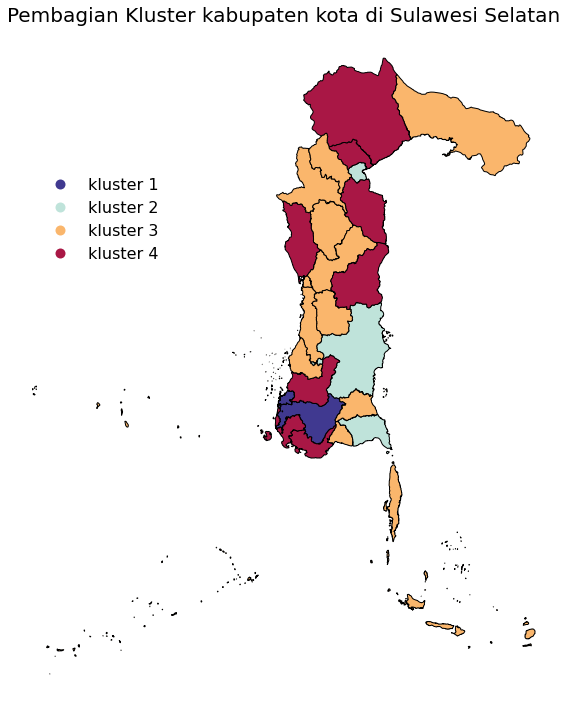

In [11]:
title = "Pembagian Kluster kabupaten kota di Sulawesi Selatan"
fig, ax = plt.subplots(1, figsize=(15,10))
gdf.plot(column='kluster', categorical=True, cmap=new_cmap, linewidth=1, edgecolor='0',
         legend=True, legend_kwds={'bbox_to_anchor':(0.3, 0.8),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title(title,fontsize=20)
plt.tight_layout()
plt.savefig('{}.png'.format(title),dpi=300)